In [128]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import pandas as pd

In [ ]:
def intervals_overlap(a, b, c, d , proportion, minimum=True):
    # Calculate the overlap
    overlap = min(b, d) - max(a, c)
    if minimum:
        if overlap > proportion*min(b-a,d-c) :
            return True
    else:
        if overlap > proportion*max(b-a,d-c) :
            return True

    return False


def is_in_tracts(s,e,tracts,prop=0.8,minimum=True):
    res=[]
    for tract in tracts:
        if intervals_overlap(s,e,tract[0],tract[1],prop,minimum):
            if tract[2]!='Melanesia':
                res.append(tract[2])
    return res


def compareTractsToMapAncient(coverage,dic_map,path_map,min_size = 40_000, filter = 0.99, nb_min = 3, prop=0.8, minimum=True):
    ''' 
    coverage: studies segments detected at this coverage
    dic_map: dictionnary containing the introgression map for contemporay individuals. The dictionnary has a key for each chromosome (int) and then a list of segments [start,end,geographical_origin]
    path_map: path to the introgression map for ancient samples
    min_size:  minimum length for an ancient segment to be kept in this study 
    filter: minimum similarity to archaic genome for an ancient segment to be kept in this study 
    nb_min: number of time an ancient segment needs to be found in a contemporary population to be considered present there
    prop: defines the minimum proportion of overlap between two segments to be considered a match
    minimum: if minimum is True, we only require the smaller segment to overlap for *prop* of its size with the larger one, otherwise we require both segments to have such an overlap
            i.e. if prop = 0.8 and a segment is entirely present in another one twice as large, there is a match if minimum == True, but not if minimum == False 
    '''
    df = pd.read_csv(path_map)
    dic_origins = {}
    not_present = {}
    present = {}
    for index, row in df.iterrows():
        if row['Coverage'] == coverage and int(row['Length']) > min_size and \
            (float(row['similarityImp_Neanderthal'])>filter or float(row['similarityImp_Denisovan'])>filter):
            is_present = is_in_tracts(int(row['start']),int(row['end']),dic_map[int(row['Chrom'])],prop,minimum)
            sample_name = row['individual']

            if not is_present:
                not_present[sample_name] = not_present.get(sample_name, 0) + 1
            else:
                present[sample_name] = present.get(sample_name, 0) + 1
        
            is_present = [x for x in is_present if x != 'CentralAsiaSiberia'] # We focuse on East-Asia, Europe and South-East Asia
            is_present = [x for x in is_present if is_present.count(x) >= nb_min] # A segment is considered to be found in a region if it is present at least nb_min times

            is_present = list(set(is_present))

            if is_present:
                
                sorted_origins = sorted(is_present)
                string_origins = '_'.join(map(str, sorted_origins)) # Concatenation of all regions where the segment was found
                if sample_name not in dic_origins:
                    dic_origins[sample_name] = {}
                dic_origins[sample_name][string_origins] = dic_origins[sample_name].get(string_origins, 0) + 1

    
    for key in dic_origins:
        total = sum(dic_origins[key].values())
        for elt in dic_origins[key]:
            dic_origins[key][elt]=dic_origins[key][elt]/total
            
    
    for key in dic_origins:
        if key in not_present:
            dic_origins[key]['None']= not_present[key]/(not_present[key]+present[key])
        else:
            dic_origins[key]['None']= 0


    return dic_origins


In [ ]:
# Path to the hmmix introgression map which can be downloaded from:
# https://doi.org/10.1371/journal.pgen.1007641.s012
f=open('hmmixMap.txt','r')
next(f)
dic_hmmix={}
for i in range(1,23):
    dic_hmmix[i]=[]
for line in f:
    sline=line.split('\t')
    if int(sline[4]) > 40000 and sline[1]!='X' and (int(sline[10])>10  or int(sline[11])>10  or int(sline[12])>10): # (Filters recommended in the hmmix paper)
        dic_hmmix[int(sline[1])].append([int(sline[2]),int(sline[3]),sline[8]])


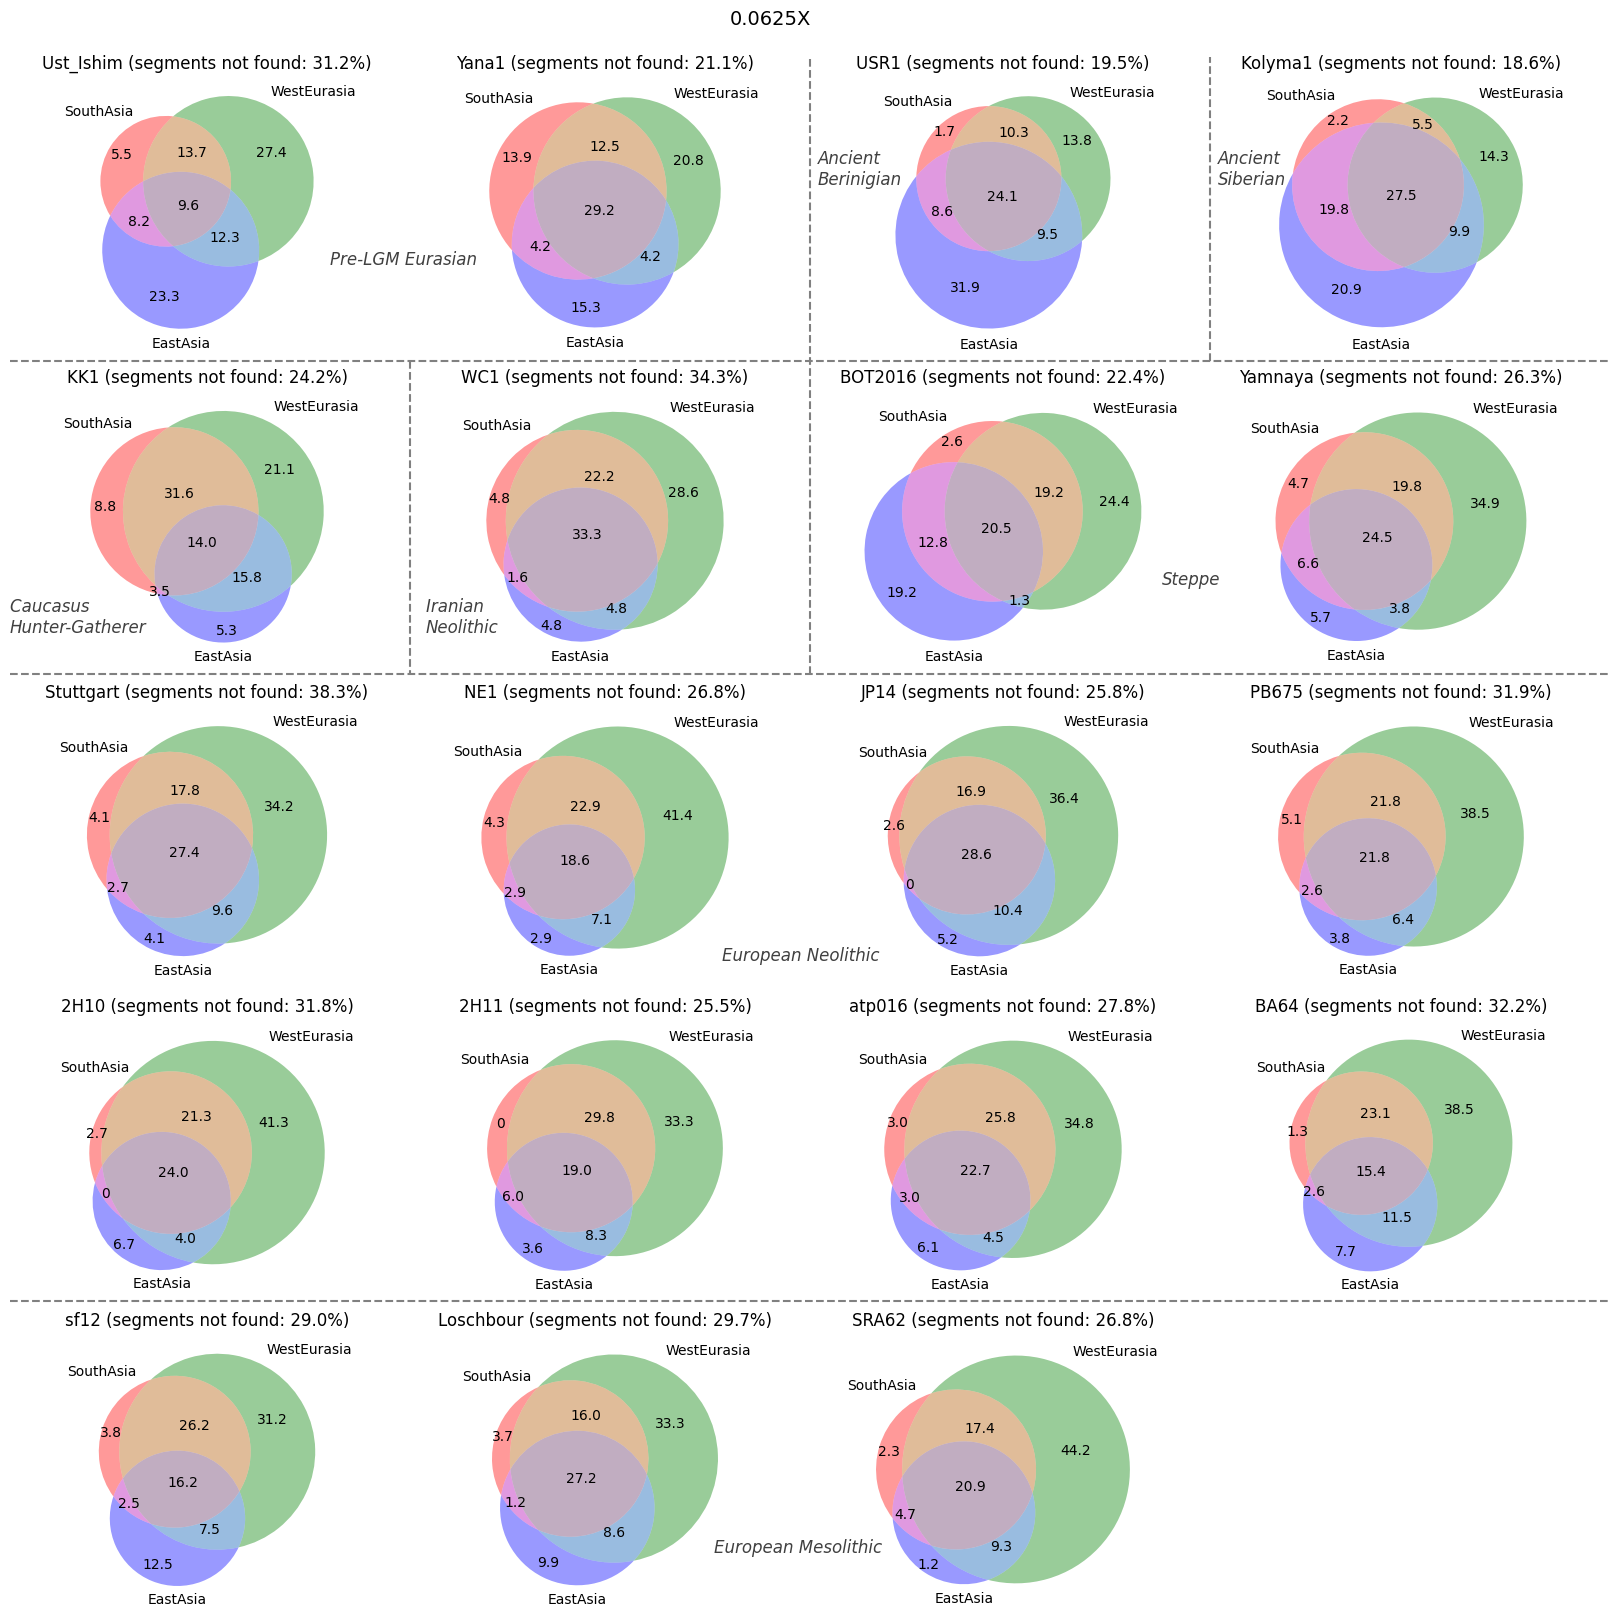

In [ ]:



# Create a grid of plots
indices_old =['USR1','Kolyma1','KK1','WC1', 'Ust_Ishim','Yana1','BOT2016','Yamnaya',
         '2H10','2H11','atp016','BA64','JP14','NE1','PB675','Stuttgart','Loschbour','sf12','SRA62']

indices =['Ust_Ishim','Yana1','USR1','Kolyma1','KK1','WC1', 'BOT2016','Yamnaya','Stuttgart','NE1','JP14',
         'PB675','2H10','2H11','atp016','BA64','sf12','Loschbour','SRA62']

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(16, 16))

axes = axes.flatten()

coverage='0.0625X'


# Path to the introgression map for ancient samples which can be downloaded from:
# https://github.com/LeoPlanche/arcAncientImputed/tree/main/maps
path_map = 'MergeFragmentsArchaic.csv'
data_hmmix = compareTractsToMapAncient(coverage, dic_hmmix,path_map)


for ax, ind in zip(axes, indices):

    data = data_hmmix[ind]

    # Extracting values for the Venn diagram and rounding to 1 decimal place
    ab = round(data['SouthAsia_WestEurasia'] * 100, 1) if 'SouthAsia_WestEurasia' in data else 0
    ac = round(data.get('EastAsia_SouthAsia', 0) * 100, 1) if 'EastAsia_SouthAsia' in data else 0
    abc = round(data['EastAsia_SouthAsia_WestEurasia'] * 100, 1) if 'EastAsia_SouthAsia_WestEurasia' in data else 0
    b = round(data['WestEurasia'] * 100, 1) if 'WestEurasia' in data else 0
    bc = round(data['EastAsia_WestEurasia'] * 100, 1) if 'EastAsia_WestEurasia' in data else 0
    c = round(data['EastAsia'] * 100, 1) if 'EastAsia' in data else 0
    a = round(data['SouthAsia']* 100, 1) if 'SouthAsia' in data else 0

    # Creating the Venn diagram
    v = venn3(subsets=(a, b, ab, c, ac, bc, abc), set_labels=('SouthAsia', 'WestEurasia', 'EastAsia'), ax=ax)

    d = round(data['None'] * 100, 1)
    for text in v.set_labels:
        text.set_fontsize(10)  # Set the desired font size here
    ax.set_title(ind + ' (segments not found: '+str(round(data['None'] * 100, 1))+'%)')
    
for extra_ax in axes[len(indices):]:
    extra_ax.axis('off')

# Separate European Neolithic from others
fig.add_artist(plt.Line2D([0, 1], [0.79, 0.79], color='gray', linestyle='--', transform=fig.transFigure))
fig.add_artist(plt.Line2D([0.5, 0.5], [0.594, 0.98], color='gray', linestyle='--', transform=fig.transFigure))
fig.add_artist(plt.Line2D([0.75, 0.75], [0.79, 0.98], color='gray', linestyle='--', transform=fig.transFigure))
fig.add_artist(plt.Line2D([0.25, 0.25], [0.79, 0.594], color='gray', linestyle='--', transform=fig.transFigure))

fig.add_artist(plt.Line2D([0, 1], [0.594, 0.594], color='gray', linestyle='--', transform=fig.transFigure))

fig.add_artist(plt.Line2D([0, 1], [0.202, 0.202], color='gray', linestyle='--', transform=fig.transFigure))

fig.text(0.505, 0.9, 'Ancient \nBerinigian', fontsize=12, color=(0.25, 0.25, 0.25),style='italic')
fig.text(0.755, 0.9, 'Ancient \nSiberian', fontsize=12, color=(0.25, 0.25, 0.25),style='italic')
fig.text(0.0, 0.62, 'Caucasus \nHunter-Gatherer', fontsize=12, color=(0.25, 0.25, 0.25),style='italic')
fig.text(0.26, 0.62, 'Iranian \nNeolithic', fontsize=12, color=(0.25, 0.25, 0.25),style='italic')

fig.text(0.2, 0.85, 'Pre-LGM Eurasian', fontsize=12, color=(0.25, 0.25, 0.25),style='italic')
fig.text(0.72, 0.65, 'Steppe', fontsize=12, color=(0.25, 0.25, 0.25),style='italic')

fig.text(0.445, 0.415, 'European Neolithic', fontsize=12, color=(0.25, 0.25, 0.25),style='italic')
fig.text(0.44, 0.045, 'European Mesolithic', fontsize=12, color=(0.25, 0.25, 0.25) ,style='italic')

fig.text(0.45, 1, f'{coverage}', fontsize=14, color='black')

# Display the plot
fig.suptitle('', fontsize=16)


plt.tight_layout()

plt.savefig(f'unique_segments_{coverage}.svg', format='svg')
plt.savefig(f'unique_segments_{coverage}.png', format='png')